In [1]:
#IMPORTS
from matplotlib.colors import LinearSegmentedColormap
from scipy.special import comb
from itertools import permutations
from functools import reduce
import time
import numpy as np
import torch 
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.datasets import ImageFolder
from torchvision.transforms import Resize, ToTensor, Normalize
from torchvision import transforms
import matplotlib.pyplot as plt
import zipfile
import re
import os

import shap
from gradcam.utils import visualize_cam
from gradcam import GradCAM, GradCAMpp
import hshap
from hshap.utils import Net, input2image

#HOME FODLER
HOME = '/home/jacopo/repo/hshap'
device = "cuda:1"

In [2]:
#LOAD PRE-TRAINED-NETWORK
model = Net()
model.load_state_dict(torch.load(os.path.join(HOME, 'data/synthetic/pretrained-models/model2.pth'), map_location=device)) 
model.to(device)
model.eval()

MEAN, STD = np.array([0.5, 0.5, 0.5]), np.array([0.5, 0.5, 0.5])
transf = transforms.Compose([ToTensor(), Normalize(mean=MEAN, std=STD)])

# LOAD TRAIN DATA
SYNTH_DATA_DIR = os.path.join(HOME, 'data/synthetic/datasets')
train_batch_size = 64
train_data = ImageFolder(root = os.path.join(SYNTH_DATA_DIR, 'train'), transform = transf)
dataloader = DataLoader(train_data, batch_size = train_batch_size, shuffle = True, num_workers = 0)
train_loader = iter(dataloader)
X, Y = next(train_loader)
X = X.to(device)
# DEFINE MASK BACKGROUND WITH AVERAGE OF TRAINING SET
background = torch.mean(X, dim = 0).detach()

Gradient Explainer:
Execution completed in 0.5847 s
Deep Explainer:
Execution completed in 0.0659 s
Hierarchical Explainer:
Initialized explainer with map size (100, 100)
Execution completed in 0.3632 s
GradCAM:
Execution completed in 0.0025 s
GradCAM++:
Execution completed in 0.0000 s
Gradient Explainer:


nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.


Execution completed in 0.4128 s
Deep Explainer:
Execution completed in 0.0693 s
Hierarchical Explainer:
Initialized explainer with map size (100, 100)
Execution completed in 0.2686 s
GradCAM:
Execution completed in 0.0026 s
GradCAM++:
Execution completed in 0.0000 s
Gradient Explainer:
Execution completed in 0.3269 s
Deep Explainer:
Execution completed in 0.0793 s
Hierarchical Explainer:
Initialized explainer with map size (100, 100)
Execution completed in 0.1638 s
GradCAM:
Execution completed in 0.0034 s
GradCAM++:
Execution completed in 0.0000 s
Gradient Explainer:
Execution completed in 0.3316 s
Deep Explainer:
Execution completed in 0.0736 s
Hierarchical Explainer:
Initialized explainer with map size (100, 100)
Execution completed in 0.4091 s
GradCAM:
Execution completed in 0.0027 s
GradCAM++:
Execution completed in 0.0000 s
Gradient Explainer:
Execution completed in 0.3264 s
Deep Explainer:
Execution completed in 0.0701 s
Hierarchical Explainer:
Initialized explainer with map size

All-NaN slice encountered


Execution completed in 0.3312 s
Deep Explainer:
Execution completed in 0.0662 s
Hierarchical Explainer:
Initialized explainer with map size (100, 100)
Execution completed in 0.3620 s
GradCAM:
Execution completed in 0.0029 s
GradCAM++:
Execution completed in 0.0000 s
Gradient Explainer:
Execution completed in 0.3280 s
Deep Explainer:
Execution completed in 0.0558 s
Hierarchical Explainer:
Initialized explainer with map size (100, 100)
Execution completed in 0.2806 s
GradCAM:
Execution completed in 0.0027 s
GradCAM++:
Execution completed in 0.0000 s
Gradient Explainer:
Execution completed in 0.3423 s
Deep Explainer:
Execution completed in 0.1757 s
Hierarchical Explainer:
Initialized explainer with map size (100, 100)
Execution completed in 0.4985 s
GradCAM:
Execution completed in 0.0028 s
GradCAM++:
Execution completed in 0.0000 s
Gradient Explainer:
Execution completed in 0.3507 s
Deep Explainer:
Execution completed in 0.0743 s
Hierarchical Explainer:
Initialized explainer with map size

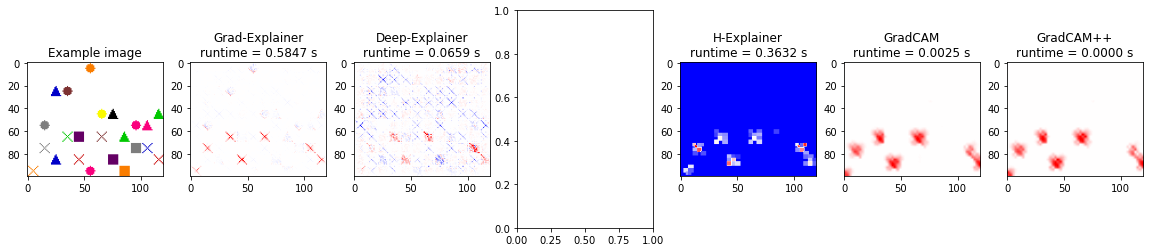

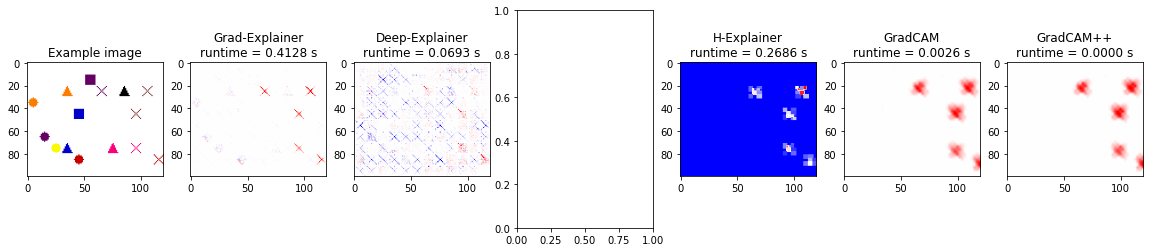

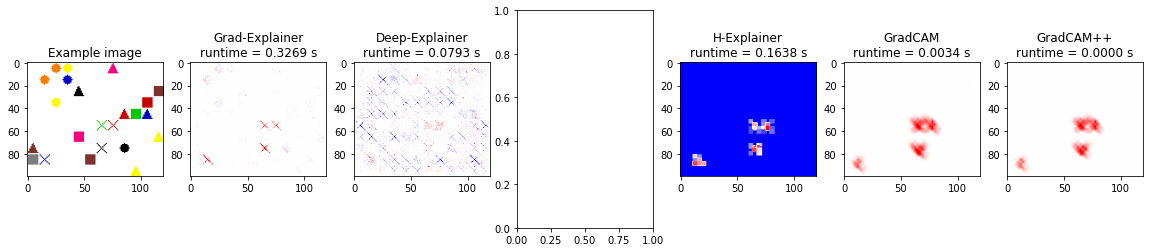

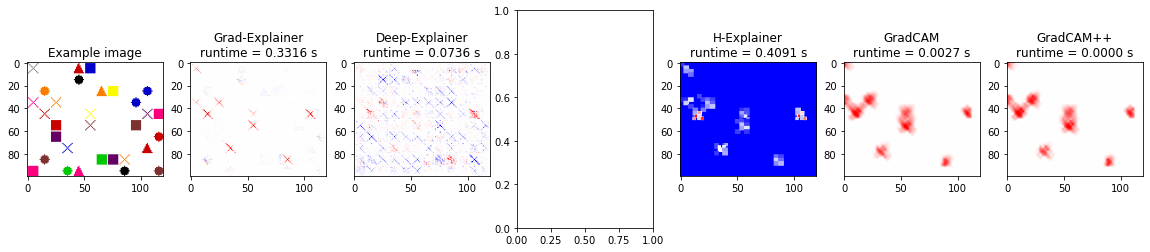

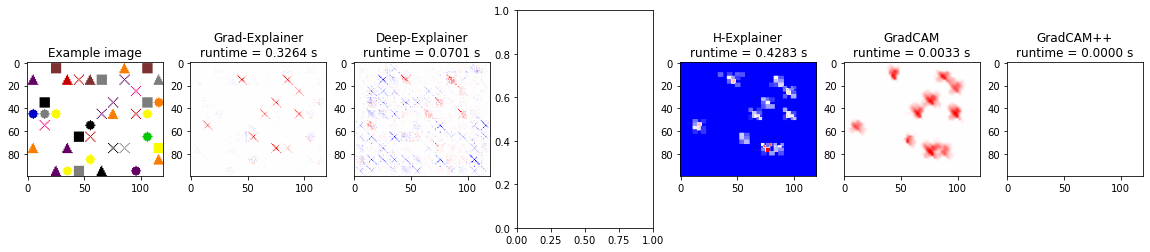

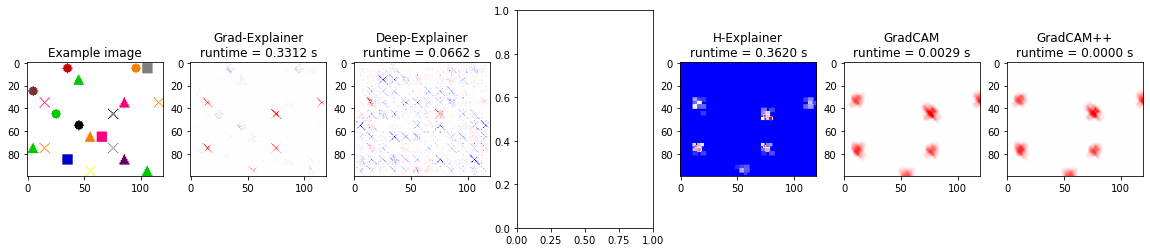

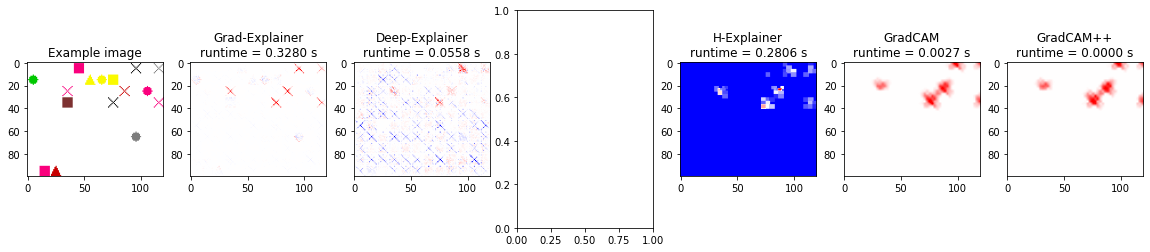

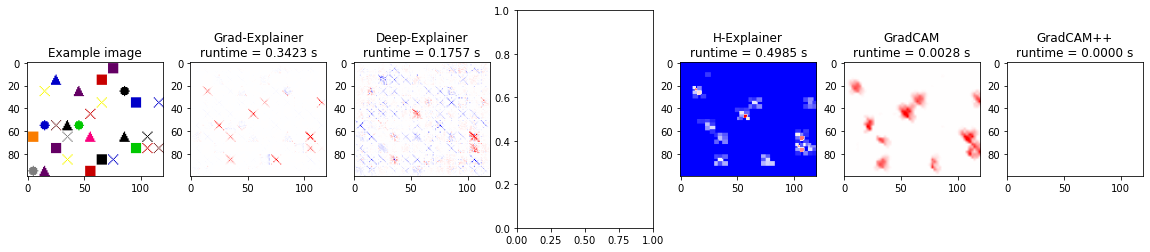

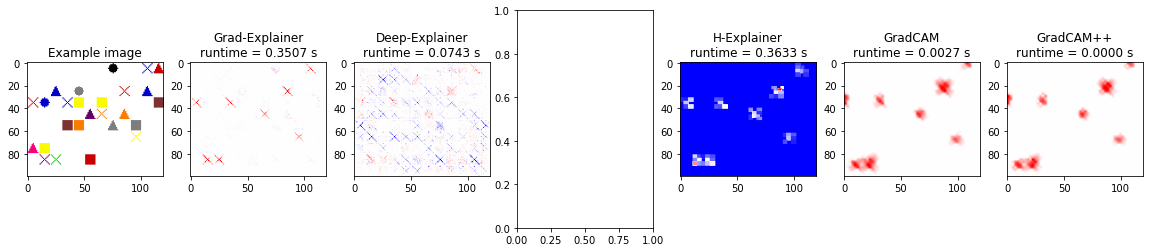

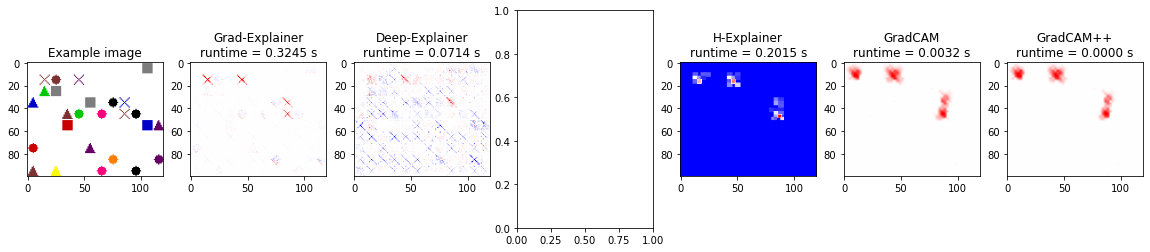

In [3]:
# DEFINE HELPER FUNCTIONS FOR KERNEL-SHAP
def mask_image(zs, segmentation, image, background = None):
  if background is None:
    background = image.mean((0,1))
  out = np.zeros((zs.shape[0], image.shape[0], image.shape[1], image.shape[2]))
  for i in range(zs.shape[0]):
    out[i,:,:,:] = image
    for j in range(zs.shape[1]):
      if zs[i,j] == 0:
        out[i][segmentation == j,:] = background
  # SHIFT CHANNELS: form (1, 100, 120, 3) to (1, 3, 100, 120)
  out2 = np.zeros((zs.shape[0], image.shape[2], image.shape[0], image.shape[1]), dtype = 'd')
  for i in range(zs.shape[0]):
    for j in range(image.shape[2]):
      out2[i, j, :, :] = out[i, :, :, j]
  out2 = torch.from_numpy(out2)
  out2 = out2.type(torch.FloatTensor).to(device)
  return out2.detach()

def fill_segmentation(values, segmentation):
  out = np.zeros(segmentation.shape)
  for i in range(len(values)):
    out[segmentation == i] = values[i]
  return out

def f(z):
  return model(mask_image(z, segments, img_orig, background = 255)).detach().numpy()

# LOAD EXAMPLE IMAGES FOLDER
EXAMPLE_DIR = os.path.join(HOME, 'data/synthetic/examples')
ImF = ImageFolder(root = EXAMPLE_DIR, transform = transf)
ImF_names = ImF.imgs
example_batch_size = 10
exloader = DataLoader(ImF, batch_size = example_batch_size, shuffle = False, num_workers = 0)
exIter = iter(exloader)
images, labels = next(exIter)
L = len(images) # number of examples
M = 4 # number of explainers

saliency_map_store = np.zeros((M, L, 100, 120))

for i in np.arange(L):

  image = images[i]

  # DEFINE OUTPUT FIGURES
  fig = plt.figure(figsize=(20, 4))
  axes = fig.subplots(1, 7)
  # SHOW EXAMPLE IMAGE
  axes[0].imshow(input2image(image, MEAN, STD))
  axes[0].set_title('Example image')

  # Extract image id
  image_name = ImF_names[i][0]
  id = int(re.search("ex(\d*).png", image_name).group(1))

  # DEFINE INPUT
  input = image.view(-1, 3, 100, 120).to(device)
  input = input.detach()

  # GRADIENT EXPLAINER
  print('Gradient Explainer:')
  gradexp = shap.GradientExplainer(model, X)
  nsamples = 200
  t0 = time.time()
  gradexp_shapley_values, gradexp_indexes = gradexp.shap_values(input, ranked_outputs = 2, nsamples = nsamples)
  tf = time.time()
  gradexp_runtime = round(tf - t0, 6)
  gradexp_saliency = gradexp_shapley_values[0][0].sum(0)
  abs_values = np.abs(gradexp_saliency.flatten())
  max_val = np.nanpercentile(abs_values, 99.9)
  # print saliency map
  axes[1].imshow(gradexp_saliency, cmap='bwr', vmin = -max_val, vmax = max_val)
  axes[1].set_title('Grad-Explainer\nruntime = %.4f s' % gradexp_runtime)
  print('Execution completed in %.4f s' % (gradexp_runtime))

  # DEEP EXPLAINER
  print('Deep Explainer:')
  deepexp = shap.DeepExplainer(model, X)
  t0 = time.time()
  deepexp_shapley_values, deepexp_indexes = deepexp.shap_values(input, ranked_outputs=2)
  tf = time.time()
  deepexp_runtime = round(tf - t0, 6)
  deepexp_saliency = deepexp_shapley_values[0][0].sum(0)
  abs_values = np.abs(deepexp_saliency.flatten())
  max_val = np.nanpercentile(abs_values, 99.9)
  # print saliency map
  axes[2].imshow(deepexp_saliency, cmap='bwr', vmin=-max_val, vmax=max_val)
  axes[2].set_title('Deep-Explainer\nruntime = %.4f s' % deepexp_runtime)
  print('Execution completed in %.4f s' % (deepexp_runtime))

  # KERNEL EXPLAINER
  #print('Kernel Explainer:')
  #from skimage.segmentation import slic
  #from keras.preprocessing import image as keras_img_tools

  #file = os.path.join(EXAMPLE_DIR, 'images/ex%d.png' % id)
  #img = keras_img_tools.load_img(file)
  #img_orig = keras_img_tools.img_to_array(img)
  # define 10x10 segments (because we know the size of a cross)
  #segments = np.zeros((100, 120))
  #width = 10
  #height = 10
  #ROW_L = int(100 / height)
  #COLUMN_L = int(120 / width)

  #segment_id = 0
  #for segment_row_id in np.arange(ROW_L + 1):
    
    #startRow = int((segment_row_id-1) * height)
    #endRow = int(segment_row_id * height)

    #for segment_column_id in np.arange(COLUMN_L + 1):

      #startColumn = int((segment_column_id-1) * width)
      #endColumn = int(segment_column_id * width)

      #segments[startRow:endRow, startColumn:endColumn] = segment_id
      #segment_id += 1


  #kernelexp = shap.KernelExplainer(f, np.zeros((1, ROW_L * COLUMN_L)))
  #t0 = time.time()
  #kernelexp_shapley_values = kernelexp.shap_values(np.ones((1, ROW_L * COLUMN_L)), nsamples = 1000)
  #tf = time.time()
  #kernelexp_runtime = round(tf - t0, 2)

  #kernelexp_saliency = fill_segmentation(kernelexp_shapley_values[1][0], segments)
  #abs_values = np.abs(kernelexp_saliency.flatten())
  #max_val = np.nanpercentile(abs_values, 99.9)
  # print saliency map
  #axes[3].imshow(kernelexp_saliency, cmap='bwr', vmin=-max_val, vmax=max_val)
  #axes[3].set_title('Kernel-Explainer\nruntime = %.2f s' % kernelexp_runtime)
  #print('Execution completed in %.2f s' % (deepexp_runtime))

  # H-SHAP EXPLAINER
  print('Hierarchical Explainer:')
  hexp = hshap.src.Explainer(model, background, 4)
  threshold = .5
  label = 1
  minW = 2
  minH = 2
  t0 = time.time()
  hexp_saliency, flatnodes = hexp.explain(image, label = label, threshold = threshold, minW = minW, minH = minH)
  tf = time.time()
  hexp_runtime = round(tf - t0, 6)
  abs_values = np.abs(hexp_saliency.flatten())
  max_val = np.nanpercentile(abs_values, 99.9)
  # print saliency map
  im = axes[4].imshow(hexp_saliency, cmap='bwr')
  axes[4].set_title('H-Explainer\nruntime = %.4f s' % hexp_runtime)
  print('Execution completed in %.4f s' % (hexp_runtime))

  
  # GRADCAM
  gradcam = GradCAM(model, model.conv2)
  print('GradCAM:')
  t0 = time.time()
  mask, _ = gradcam(input)
  tf = time.time()
  gradcam_runtime = round(tf - t0, 6)
  gradcam_saliency = mask.to("cpu").detach().squeeze().numpy()
  abs_values = np.abs(gradcam_saliency.flatten())
  max_val = np.nanpercentile(abs_values, 99.9)
  # print saliency map
  axes[5].imshow(gradcam_saliency, cmap='bwr', vmin=-max_val, vmax=max_val)
  axes[5].set_title('GradCAM\nruntime = %.4f s' % gradcam_runtime)
  print('Execution completed in %.4f s' % (gradcam_runtime))

  # GRADCAM++
  gradcampp = GradCAMpp(model, model.conv2)
  print('GradCAM++:')
  t0 = time.time()
  maskpp, _ = gradcampp(input)
  tf = time.time()
  gradcampp_runtime = round(tf - t0, 2)
  gradcampp_saliency = maskpp.to("cpu").detach().squeeze().numpy()
  abs_values = np.abs(gradcampp_saliency.flatten())
  max_val = np.nanpercentile(abs_values, 99.9)
  # print saliency map
  axes[6].imshow(gradcampp_saliency, cmap='bwr', vmin=-max_val, vmax=max_val)
  axes[6].set_title('GradCAM++\nruntime = %.4f s' % gradcampp_runtime)
  print('Execution completed in %.4f s' % (gradcampp_runtime))
  
plt.show()